# Exploratory Data Analysis with Labeled Reviews Dataset

Note: This notebook was executed in Google Colab with GPU as the runtime



In [39]:
# mounts my drive onto google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statistics as stats

## week 3 imports
import missingno as msno     
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Linear and general modeling imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Feature Engineering
from sklearn.preprocessing import StandardScaler, PolynomialFeatures   # Scale/transform/feature engineering
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# imports mice
# from impyute.imputation.cs import mice

import patsy
# y, X = patsy.dmatrices(formula, data=diamonds, return_type='dataframe')

# GridSearch and Hyperparameter Tuning
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

# Logistic and Classification metrics
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler

# naive bayes imports
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# SVMs
from sklearn.svm import LinearSVC, SVC

# Decision Trees
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Import Bagging, Boosting, and Random Forests, and ExtraTrees (Extremely Randomized Trees)
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor


In [2]:
# !pip install nltk

In [3]:
# imports NLP libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
# nltk.download() # --> Download all, and then restart jupyter lab
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snchu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Functions to be used for cleaning 

# Keeps the words only function
def keep_words_only(text):
    """Cleans text so that any special characters are removed and only words are kept"""
    
    # Instantiates tokenizer
    regex_tokenizer = RegexpTokenizer("\w+[']*")
    
    # tokenizes the text
    words = regex_tokenizer.tokenize(text.lower())
    
    # Takes out stopwords
    stopwords_list = stopwords.words('english')
    no_stops_words = [word for word in words if word.lower() not in stopwords_list]
    
    return (' ').join(no_stops_words)



def clean_text_stem(text):
    """Cleans text by keeping words only, tokenizing, stemming and removing stopwords"""
    #Instantiate tokenizer and stemmer and lemmatizer
    re_tokenizer = RegexpTokenizer("\w+")
    lemmatizer = WordNetLemmatizer()
    p_stemmer = PorterStemmer()
        
    # Tokenze the text
    words = re_tokenizer.tokenize(text.lower())
    
    # Filter stop words
    stopwords_list = stopwords.words('english')
    
     # Adds custom stopwords to stopwords_list
#     custom = []
#     stopwords_list = stopwords_list + custom

    no_stops_stemmed = [p_stemmer.stem(word) for word in words if word.lower() not in stopwords_list]
    
    return (' ').join(no_stops_stemmed)

In [5]:
# Loads review data
# reviews_df = pd.read_csv('/content/drive/MyDrive/MSBA Smith School/General Assembly/Colab/labeled_reviews.csv')

reviews_df = pd.read_csv('../Data/reviews_labeled.csv')

In [6]:
reviews_df.head()

,business_id,name,review_id,review_stars,text,amb_casual,amb_classy,amb_target
0,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,wve8w6gIuPpCfo5J--AHjg,3,"The menu sounded promising, with over fifty di...",0.0,0.0,0
1,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,5rFuHGGbimVxPHxgM0sNSA,3,This wasn't the worst Chinese food but it wasn...,0.0,0.0,0
2,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,2iD3Rdbw0DUzjZSqBq3hXQ,1,I have been coming to this restaurant for over...,0.0,0.0,0
3,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,e61y5ZlNwg04mAGtcD3vbQ,5,My husband and I love this place.\nGreat price...,0.0,0.0,0
4,kZFTi8FKjs30EuzurZ3v3g,Donerick's Pub,38lN2ONaypsfBDLwhGxcSg,5,Great place for beverages with your friends wh...,0.0,0.0,0


In [46]:
# Checks for any nulls in the dataset
reviews_df.isnull().sum()

business_id     0
name            0
review_id       0
review_stars    0
text            0
amb_casual      0
amb_classy      0
amb_target      0
dtype: int64

In [47]:
# Checks the value_counts of the target variable/baseline score
reviews_df['amb_target'].value_counts(dropna=False)

1    44211
3    18880
2    13848
0    12408
Name: amb_target, dtype: int64

In [48]:
# Creates a new column that reflects the length or word count for each review
reviews_df['text_length'] = reviews_df['text'].map(lambda x: len(x.split(' ')))

In [49]:
# Creates a new clean_text column that removes any special characters from the review text
reviews_df['clean_text'] = reviews_df['text'].map(keep_words_only)

In [50]:
# Creates a new column that reflects the length or word count of each clean text review
reviews_df['clean_text_length'] = reviews_df['clean_text'].map(lambda x: len(x.split(' ')))

In [51]:
reviews_df.head()

,business_id,name,review_id,review_stars,text,amb_casual,amb_classy,amb_target,text_length,clean_text,clean_text_length
0,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,wve8w6gIuPpCfo5J--AHjg,3,"The menu sounded promising, with over fifty di...",0.0,0.0,0,121,menu sounded promising fifty different dishes ...,68
1,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,5rFuHGGbimVxPHxgM0sNSA,3,This wasn't the worst Chinese food but it wasn...,0.0,0.0,0,78,wasn' worst chinese food wasn' best egg foo yo...,41
2,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,2iD3Rdbw0DUzjZSqBq3hXQ,1,I have been coming to this restaurant for over...,0.0,0.0,0,52,coming restaurant 20 years purchased shrimp fr...,27
3,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,e61y5ZlNwg04mAGtcD3vbQ,5,My husband and I love this place.\nGreat price...,0.0,0.0,0,23,husband love place great price lot food make s...,13
4,kZFTi8FKjs30EuzurZ3v3g,Donerick's Pub,38lN2ONaypsfBDLwhGxcSg,5,Great place for beverages with your friends wh...,0.0,0.0,0,61,great place beverages friends watch game lots ...,43


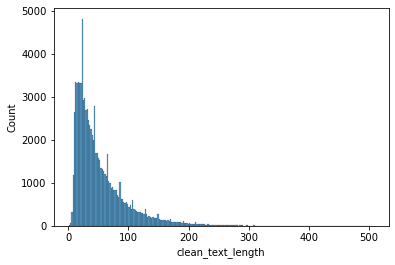

In [52]:
# Displays the distribution of the review word count using a histogram
sns.histplot(reviews_df['clean_text_length']);

**Interpretation**: Many reviews are less than 200 words. The distribution of review lengths is skewed to the right. 

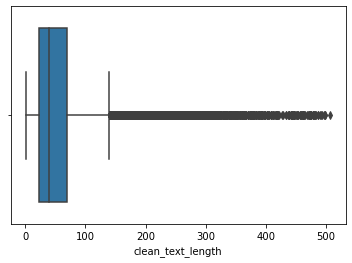

In [53]:
# Displays the distribution of the review word count using a boxplot 
sns.boxplot(x=reviews_df['clean_text_length']);

**Interpretation**: This boxplot is showing something similar to the histogram of the review lengths.  Again the distribution of the review lengths is skewed to the right with a lot of outliers to the right.  A majority of the review lengths tend to stay less than 200 words. 

In [54]:
# Looks at the distribution of the word count through summary statistics
reviews_df['clean_text_length'].describe()

count    89347.000000
mean        54.190672
std         48.274675
min          1.000000
25%         22.000000
50%         39.000000
75%         69.000000
max        507.000000
Name: clean_text_length, dtype: float64

**Interpretation**: The mean word count of reviews is 103 words.  The minimum count of words in a review is 1 word, and that is before taking out stop words.  Will likely have to omit certain reviews due to the word count being too small. 

In [55]:
# Checks the mode of the word count in reviews
stats.mode(reviews_df['clean_text_length'])

20

### Stems the reviews

In [56]:
# Creates a new clean text column, which contains only the stemmed words from the reviews
reviews_df['clean_text_stem'] = reviews_df['text'].map(clean_text_stem)

In [57]:
# Creates a new column that reflects the length or word count of each clean_text stem review
reviews_df['clean_text_stem_length'] = reviews_df['clean_text_stem'].map(lambda x: len(x.split(' ')))

In [58]:
reviews_df.head()

,business_id,name,review_id,review_stars,text,amb_casual,amb_classy,amb_target,text_length,clean_text,clean_text_length,clean_text_stem,clean_text_stem_length
0,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,wve8w6gIuPpCfo5J--AHjg,3,"The menu sounded promising, with over fifty di...",0.0,0.0,0,121,menu sounded promising fifty different dishes ...,68,menu sound promis fifti differ dish differ sty...,66
1,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,5rFuHGGbimVxPHxgM0sNSA,3,This wasn't the worst Chinese food but it wasn...,0.0,0.0,0,78,wasn' worst chinese food wasn' best egg foo yo...,41,worst chines food best egg foo young dri overc...,39
2,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,2iD3Rdbw0DUzjZSqBq3hXQ,1,I have been coming to this restaurant for over...,0.0,0.0,0,52,coming restaurant 20 years purchased shrimp fr...,27,come restaur 20 year purchas shrimp fri rice g...,26
3,0lCiLKpjrinltPFbBby4sw,The Great Wall Restaurant,e61y5ZlNwg04mAGtcD3vbQ,5,My husband and I love this place.\nGreat price...,0.0,0.0,0,23,husband love place great price lot food make s...,13,husband love place great price lot food make s...,12
4,kZFTi8FKjs30EuzurZ3v3g,Donerick's Pub,38lN2ONaypsfBDLwhGxcSg,5,Great place for beverages with your friends wh...,0.0,0.0,0,61,great place beverages friends watch game lots ...,43,great place beverag friend watch game lot tv g...,43


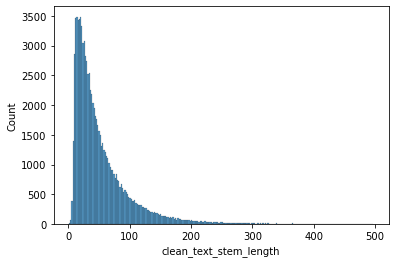

In [59]:
# Displays the distribution of the cleaned, stemmed review word count using a histogram
sns.histplot(reviews_df['clean_text_stem_length']);

**Interpretation**: After stemming the reviews, the length of the reviews became significantly shorter nad now, a majority of the reviews are below 100 stemmed words/words that give the review meaning.  The graph, however, is still skewed to the right. 

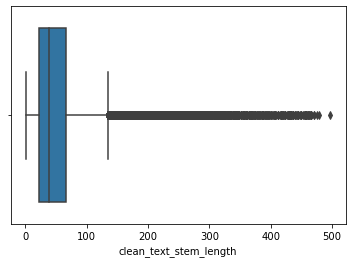

In [60]:
# Displays the distribution of the cleaned, stemmed, review word count using a boxplot 
sns.boxplot(x=reviews_df['clean_text_stem_length']);

**Interpretation**: This boxplot also reflects the observation made earlier showing that a majority of reviews are less than 100 stemmed words, with a significant amount of outliers to the right/right skewed. 

In [61]:
# Looks at the distribution of the cleaned, stemmed word count through summary statistics
reviews_df['clean_text_stem_length'].describe()

count    89347.000000
mean        52.365463
std         46.539715
min          1.000000
25%         22.000000
50%         38.000000
75%         67.000000
max        497.000000
Name: clean_text_stem_length, dtype: float64

**Interpretation**: After stemming the words, the average amount of stemmed words in each review is about 52 stemmed words.  The minimum number of words is still 1, which again, will probably lead to dropping rows that have very few words. 

In [62]:
# Checks the number of nulls 
reviews_df.isnull().sum()

business_id               0
name                      0
review_id                 0
review_stars              0
text                      0
amb_casual                0
amb_classy                0
amb_target                0
text_length               0
clean_text                0
clean_text_length         0
clean_text_stem           0
clean_text_stem_length    0
dtype: int64

In [63]:
# Keeps only those reviews that have more than 10 words
reviews_df = reviews_df[reviews_df['clean_text_stem_length'] > 10]

In [64]:
# Checks the shape of the dataframe 
reviews_df.shape

(86189, 13)

In [65]:
# Saves reviews_df as a csv file
reviews_df.to_csv('../Data/reviews_stemmed.csv', index=False)

#### Randomly Sampling 50% of the majority class (amb_target == 1) / when a restaurant is casual only

In [7]:
# Loads the saved data
df = pd.read_csv('../Data/reviews_stemmed.csv')

In [8]:
df.shape

(86189, 13)

In [68]:
df['amb_target'].value_counts()

1    42644
3    18157
2    13453
0    11935
Name: amb_target, dtype: int64

In [69]:
# Separates the dataframe into 'only casual' vs. 'everything but causal only'
casual_only_df = df[df['amb_target'] == 1]
other_df = df[df['amb_target'] != 1]

In [70]:
casual_only_df.shape

(42644, 13)

In [71]:
# Samples 50% of the casual only df
casual_only_df = casual_only_df.sample(frac=0.50)

In [72]:
casual_only_df.shape

(21322, 13)

In [73]:
# Concatenates the undersampled casual only df with the 'everything but casual only' df
new_df = pd.concat([casual_only_df, other_df])

In [74]:
# Sorts the dataframe by original index
new_df.sort_index(inplace=True)

In [75]:
new_df.shape

(64867, 13)

In [76]:
new_df['amb_target'].value_counts(normalize=True)

1    0.328703
3    0.279911
2    0.207394
0    0.183992
Name: amb_target, dtype: float64

In [77]:
new_df.to_csv('../Data/reviews_stemmed_balanced.csv', index=False)

### EDA with TfidfVectorizing Stemmed Text

In [78]:
# Renames and makes a copy of the reviews_df
df = reviews_df.copy()

In [79]:
# Checks the target data type
df['amb_target'].dtype

dtype('int64')

In [80]:
# Creates different dataframes based on target class
neither_amb = df[df['amb_target'] == 0].copy()
casual_amb = df[df['amb_target'] == 1].copy()
classy_amb = df[df['amb_target'] == 2].copy()
both_amb = df[df['amb_target'] == 3].copy()

In [81]:
# Instantiates TfidfVectorizer with default hyperparameters
tvec = TfidfVectorizer()

In [82]:
# Defines the X for each dataframe 
X_neither = neither_amb['clean_text_stem']
X_casual = casual_amb['clean_text_stem']
X_classy = classy_amb['clean_text_stem']
X_both = both_amb['clean_text_stem']

#### Most common words for restaurants that are neither casual nor classy

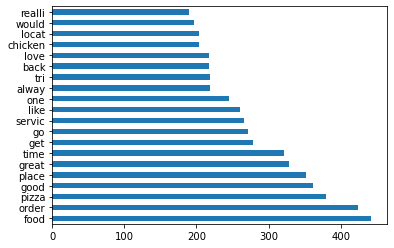

In [83]:
# Fits and transforms the vectorizer on corpus
X_neither = tvec.fit_transform(X_neither)

# Turns it into a dataframe
X_neither_df = pd.DataFrame(X_neither.toarray(), columns=tvec.get_feature_names())

# plots top occurring words for restaurants that are neither casual nor classy
common_stem_words = X_neither_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
common_stem_words;

#### Most common words for restaurants that are casual only

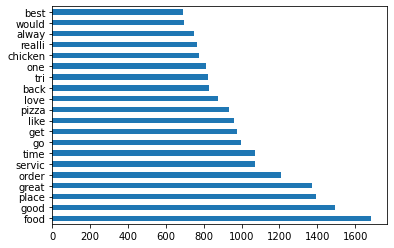

In [84]:
# Fits and transforms the vectorizer on corpus
X_casual = tvec.fit_transform(X_casual)

# Turns it into a dataframe
X_casual_df = pd.DataFrame(X_casual.toarray(), columns=tvec.get_feature_names())

# plots top occurring words for restaurants that are neither casual nor classy
common_stem_words = X_casual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
common_stem_words;

#### Most common words for restaurants that are classy only

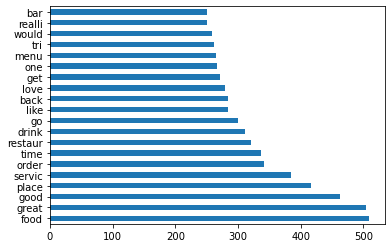

In [85]:
# Fits and transforms the vectorizer on corpus
X_classy = tvec.fit_transform(X_classy)

# Turns it into a dataframe
X_classy_df = pd.DataFrame(X_classy.toarray(), columns=tvec.get_feature_names())

# plots top occurring words for restaurants that are neither casual nor classy
common_stem_words = X_classy_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
common_stem_words;

#### Most common words for restaurants that are both casual and classy

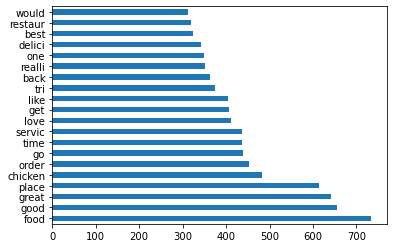

In [86]:
# Fits and transforms the vectorizer on corpus
X_both = tvec.fit_transform(X_both)

# Turns it into a dataframe
X_both_df = pd.DataFrame(X_both.toarray(), columns=tvec.get_feature_names())

# plots top occurring words for restaurants that are neither casual nor classy
common_stem_words = X_both_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
common_stem_words;